# Imports

In [1]:
import os
import zipfile
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2025-01-18 18:18:54.296062: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 18:18:54.296121: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 18:18:54.297484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 18:18:54.406392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Estrazione del dataset

In [2]:
DATASET_ZIP_PATH="animals.zip"
DATASET_IMGS_DESTDIR="./"

if not os.path.isdir(DATASET_IMGS_DESTDIR + "animals"):
    if not os.path.isfile(DATASET_ZIP_PATH):
        raise FileNotFoundError(f" !! Unable to continue, could not find zipped dataset to extract dataset from: {DATASET_ZIP_PATH}")

    with zipfile.ZipFile(DATASET_ZIP_PATH, mode="r") as animalz:
        animalz.extractall(DATASET_IMGS_DESTDIR)

# Caricamento del dataset e split

In [44]:
(training_set, testing_set) = keras.utils.image_dataset_from_directory(
    DATASET_IMGS_DESTDIR + "animals",
    subset="both",
    seed=1234,
    validation_split=0.3,
    image_size=(224,224),
    label_mode="categorical",
    batch_size=8)

Found 26128 files belonging to 10 classes.
Using 18290 files for training.
Using 7838 files for validation.


In [45]:
train_size = int(0.8 * len(training_set))
val_size = int(0.2 * len(training_set))
train_dataset = training_set.take(train_size)
validation_dataset = training_set.skip(train_size).take(val_size)

In [46]:
print("Train batches:", len(train_dataset))
print("Validation batches:", len(validation_dataset))

Train batches: 1829
Validation batches: 457


# Costruzione del modello

In [131]:
def build_model(your_base_model, input_shape=(224,224,3)):
    top_layers = 0

    def atlay(x):
        nonlocal top_layers
        top_layers += 1
        return x

    seq_model = keras.Sequential([
        keras.Input(shape=input_shape),
        keras.layers.Rescaling(scale=1. / 255),
        your_base_model(include_top=False, input_shape=input_shape),
        atlay(keras.layers.GlobalAveragePooling2D()),
        atlay(keras.layers.Dropout(0.25)),
        atlay(keras.layers.Dense(
            10,
            kernel_initializer=keras.initializers.GlorotUniform(),
            bias_initializer=keras.initializers.GlorotUniform(),
            activation=keras.activations.softmax))
    ])
    
    freezing_layers = seq_model.layers[:len(seq_model.layers) - top_layers]
    for layer in freezing_layers:
        layer.trainable = False

    return (seq_model, top_layers)

In [132]:
(model, model_added_top_layers) = build_model(keras.applications.MobileNet)

In [133]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_29 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
 8 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_29 (Dropout)        (None, 1024)              0         
                                                                 
 dense_71 (Dense)            (None, 10)                10250     
                                                                 
Total params: 3239114 (12.36 MB)
Trainable params: 10

# Addestramento del modello

## Transfer learning

In [134]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy()
    ])

transfer_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(
            start_from_epoch=3,
            patience=3,
            restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(
            lambda e, l: l if e < 1 else l * np.exp(-0.25)
        )])

Epoch 1/50
1829/1829 [==============================] - 34s 18ms/step - loss: 0.3291 - categorical_accuracy: 0.8945 - val_loss: 0.1661 - val_categorical_accuracy: 0.9499 - lr: 0.0010
Epoch 2/50
1829/1829 [==============================] - 32s 18ms/step - loss: 0.1598 - categorical_accuracy: 0.9492 - val_loss: 0.1452 - val_categorical_accuracy: 0.9562 - lr: 7.7880e-04
Epoch 3/50
1829/1829 [==============================] - 32s 17ms/step - loss: 0.1284 - categorical_accuracy: 0.9582 - val_loss: 0.1421 - val_categorical_accuracy: 0.9579 - lr: 6.0653e-04
Epoch 4/50
1829/1829 [==============================] - 32s 17ms/step - loss: 0.1135 - categorical_accuracy: 0.9633 - val_loss: 0.1466 - val_categorical_accuracy: 0.9601 - lr: 4.7237e-04
Epoch 5/50
1829/1829 [==============================] - 32s 17ms/step - loss: 0.1034 - categorical_accuracy: 0.9657 - val_loss: 0.1345 - val_categorical_accuracy: 0.9636 - lr: 3.6788e-04
Epoch 6/50
1829/1829 [==============================] - 32s 18ms/step

## Salvataggio pesi correnti

In [135]:
model.save_weights('./checkpoints/nasnetmobile_tl_noqnt_noft')

# Provare a fare predizioni

1/1 [==============================] - 0s 18ms/step


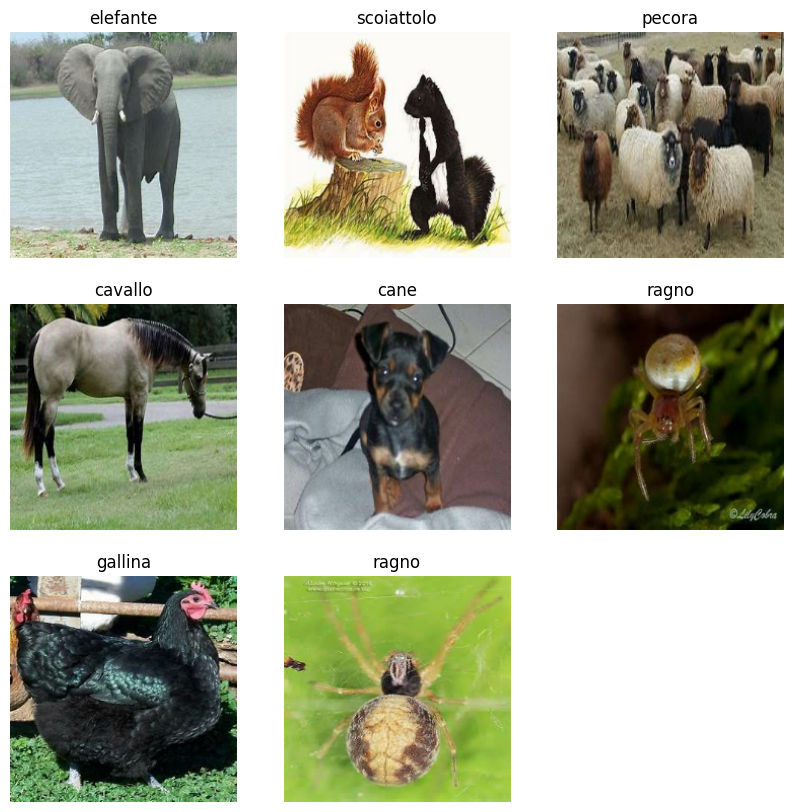

In [136]:
def predict_3x3_from_dataset(dataset, m):
    d = {
        0 : "cane",
        1 : "cavallo",
        2 : "elefante",
        3 : "farfalla",
        4 : "gallina",
        5 : "gatto",
        6 : "mucca",
        7 : "pecora",
        8 : "ragno",
        9 : "scoiattolo"
    }

    shuffled_dataset = dataset.take(1).shuffle(buffer_size=1000)
    plt.figure(figsize=(10, 10))
    for images, labels in shuffled_dataset:
      for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        resized = tf.image.resize([images[i]], (224,224))
        inputs = tf.reshape(resized, (1, 224, 224, 3))
        y = m.predict(inputs)
        plt.title(d[np.argmax(y)])
        plt.axis("off")

predict_3x3_from_dataset(validation_dataset, model)